## PyTorch RNN Tutorial - Name Classification Using A Recurrent Neural Net

https://www.youtube.com/watch?v=WEV61GmmPrk

<img src="images/rnn-first.png">

<img src="images/rnn-unfolded.png">

<img src="images/rnn-applications.png">

<img src="images/rnn-pros-cons.png">

<img src="images/rnn-one-hot.png">

<img src="images/rnn-name-classification.png">

Further readings:  

https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks#architecture

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html


**Note that pics and content taken from https://github.com/python-engineer/pytorch-examples just while learning the apis of pytorch myself** 


In our examples we will do name classification - data is from names of people from 18 different countries.

Data taken from [here](https://download.pytorch.org/tutorial/data.zip)

and stored here  /Users/jvsingh/work/github/python_codes/learn/data/rnn-data 


We will take whole name as a sequence and put in rnn as one input

In [25]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/rnn-data/data/names/*.txt'):
        #print(f"Debug: filename: {filename}")
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# This gives random choice from names and return correspoding country
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [26]:
print(ALL_LETTERS)
# This leaves only
print(unicode_to_ascii('Ślusàrski'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski


In [28]:
# We use one-hot encoding 
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [32]:
# each letter is 57-dim one-hot vector (1 x 57) 
# and 5 letter word => 5 x 1 x 57
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


In [31]:
# Loads data from /Users/jvsingh/work/github/python_codes/ml-python/pytorch_tut
category_lines, all_categories = load_data()
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

##### NOTE
**all_categories** => All countries ie the categories or classifications

**category_lines** => Dictionary of country/category => list of names

In [35]:
#all_categories
#category_lines

## WRITE RNN HERE

<img src="images/rnn-name-classification.png">

In [37]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

# Not needed to import as we have defined in this notebook itself
# from utils import ALL_LETTERS, N_LETTERS
# from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example



class RNN(nn.Module):
    # note that nn.RNN module avilable in python
    # we are impmeenting from scratch for a better understanding
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # output two hidden layers : we combine them (is one layer with different array loc??)
        # how does this combine work - may be python engineer tells later
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # U Arrow in pic
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # W Arrow in pic
        # Softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        # then we apply our linear layer
        hidden  = self.i2h(combined)
        output  = self.i2o(combined)
        output  = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


Above is what we need for RNN implementation

In [38]:
# Load data 
# category_lines : dict of country name => names list
# all_categories : list of names of all countries
category_lines, all_categories = load_data()

# Number of categories/countries
n_categories = len(all_categories)
print(f'n_categories: {n_categories}')

n_categories: 18


We have 18 categories for 18 country files 

##### Just to check if this is working:

In [41]:
# Hyper parameters. We can define anything - lets do 128 first
n_hidden = 128

# 
rnn = RNN(N_LETTERS, n_hidden, n_categories) # N_LETTERS = 57

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
#print(f"hidden_tensor: {hidden_tensor}")

# process this: forward pass
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(f'output.size(): {output.size()}')
print(f'next_hidden.size(): {next_hidden.size()}')


output.size(): torch.Size([1, 18])
next_hidden.size(): torch.Size([1, 128])


We saw how it above for one character - now we do it for a sequence. Each character is one input. Then in the last we take the output and apply softmax, then chose one with highest probability 

<img src="images/rnn-unfolded.png">

In [20]:
# whole sequence name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
print(f'input_tensor.size(): {input_tensor.size()}')
print(f'hidden_tensor.size(): {hidden_tensor.size()}')

# we have to repeatedly apply for each character
output, next_hidden = rnn(input_tensor[0], hidden_tensor) #not this calls to forward
print(f'output.size(): {output.size()}')
print(f'next_hidden.size(): {next_hidden.size()}')

input_tensor.size(): torch.Size([6, 1, 57])
hidden_tensor.size(): torch.Size([1, 128])
output.size(): torch.Size([1, 18])
next_hidden.size(): torch.Size([1, 128])


In [21]:

def category_from_output(output):
    # we want to return index of greatest value
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Scottish


4999 4.999  1.6971 Song / Chinese  CORRECT
9999 9.998999999999999  1.9713 Mclean / Irish  WRONG (Scottish)
14999 14.999  4.4162 Maas / Vietnamese  WRONG (German)
19999 19.999  4.3916 Turulo / Portuguese  WRONG (Russian)
24999 24.999  1.7381 Zhou / Korean  WRONG (Chinese)
29999 29.999  1.3806 D'cruz / Spanish  WRONG (Portuguese)
34999 34.999  0.7649 Basurto / Portuguese  CORRECT
39999 39.999  0.8123 Basara / Arabic  CORRECT
44999 44.999  1.3020 Coiro / Portuguese  WRONG (Italian)
49999 49.999  0.0487 O'Neill / Irish  CORRECT
54999 54.998999999999995  1.3266 Zientek / Polish  CORRECT
59999 59.999  0.6387 Hnizdil / Czech  CORRECT
64999 64.999  0.9839 Marek / Polish  CORRECT
69999 69.999  2.8306 Spoerl / Dutch  WRONG (Czech)
74999 74.99900000000001  0.6490 Mei / Chinese  CORRECT
79999 79.999  0.2884 Kuijpers / Dutch  CORRECT
84999 84.999  0.7561 Sedmik / Czech  CORRECT
89999 89.999  0.1856 Glynatsis / Greek  CORRECT
94999 94.999  3.4561 Petit / French  WRONG (Spanish)
99999 99.999000000000

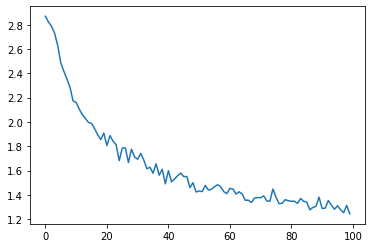

In [45]:

#-------------- Training here ---------------#

# 1. set up optimizer
criterion = nn.NLLLoss() # negative log likelihood
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

# 2. Train for one word ie name/country
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    # looping through all letters of name
    for i in range(line_tensor.size()[0]): #line_tensor.size()[0]: length of name
        output, hidden = rnn(line_tensor[i], hidden) # note this calls to forward
        
    # Loss will be only on final output - as we are 
    # doing many to 1(final country classification)    
    loss = criterion(output, category_tensor)
    
    # gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # WHY are we returning output here? i think not needed
    # output -> Just for printing later in diagnostics while training progress
    return output, loss.item()  
    

    
# 3. Train for many iterations (kind of epochs, but not in true sense as we 
#    are doing random selection of examples)
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000


for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, 
                                                                           all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss/plot_steps) # average loss
        current_loss = 0
    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f'{i} {i/n_iters*100}  {loss:.4f} {line} / {guess}  {correct}')
        
plt.figure()
plt.plot(all_losses)
plt.show()


In [46]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
            
        guess = category_from_output(output)
        print(guess)
        
while True:
    sentence = input("Input: ")
    if sentence == "quit":
        break
    
    predict(sentence)

Input: Mikhail

> Mikhail
Japanese
Input: Recce

> Recce
German
Input: Alexander

> Alexander
German
Input: quit


 Pretty bad :( 
 
 but i learned how to do :)